In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Net(tf.keras.Model):
    """
    Convolutional Neural Network for PPO (TensorFlow version)
    """

    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = models.Sequential([  # input shape (None, 96, 96, img_stack)
            layers.Conv2D(8, kernel_size=4, strides=2, activation='relu', input_shape=(96, 96, img_stack)),
            layers.Conv2D(16, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(64, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(128, kernel_size=3, strides=1, activation='relu'),
            layers.Conv2D(256, kernel_size=3, strides=1, activation='relu'),
        ])  # Output shape will be (None, 1, 1, 256)

        self.v = models.Sequential([
            layers.Dense(100, activation='relu'),
            layers.Dense(1)  # Value function output (v)
        ])

        self.fc = models.Sequential([
            layers.Dense(100, activation='relu')
        ])

        self.alpha_head = layers.Dense(3, activation='softplus')
        self.beta_head = layers.Dense(3, activation='softplus')

    def call(self, inputs):
        x = self.cnn_base(inputs)
        x = tf.reshape(x, (-1, 256))  # Flattening to (batch_size, 256)
        
        v = self.v(x)
        
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1  # Adding 1 to the output for alpha
        beta = self.beta_head(x) + 1    # Adding 1 to the output for beta
        
        return (alpha, beta), v

# Example usage:
# model = Net(img_stack=4)
# output = model(some_input)


# import tensorflow as tf
# from tensorflow.keras import layers, models

# class Net(tf.keras.Model):
#     """
#     Convolutional Neural Network for PPO (TensorFlow version)
#     """

#     def __init__(self, img_stack):
#         super(Net, self).__init__()
        
#         # CNN base: Processing the image input
#         self.cnn_base = models.Sequential([  # input shape (None, 96, 96, img_stack)
#             layers.Conv2D(8, kernel_size=4, strides=2, activation='relu', input_shape=(96, 96, img_stack)),
#             layers.Conv2D(16, kernel_size=3, strides=2, activation='relu'),
#             layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
#             layers.Conv2D(64, kernel_size=3, strides=2, activation='relu'),
#             layers.Conv2D(128, kernel_size=3, strides=1, activation='relu'),
#             layers.Conv2D(256, kernel_size=3, strides=1, activation='relu'),
#         ])  # Output shape will be (None, 1, 1, 256)

#         # Value function output: Scalar value for each state
#         self.v = models.Sequential([
#             layers.Dense(100, activation='relu'),
#             layers.Dense(1)  # Scalar value output (v)
#         ])

#         # Shared Fully Connected layers for both policy and value estimation
#         self.fc = models.Sequential([
#             layers.Dense(100, activation='relu')
#         ])

#         # Policy head: Outputs alpha and beta for Beta distribution
#         self.alpha_head = layers.Dense(3, activation='softplus')  # Alpha parameters
#         self.beta_head = layers.Dense(3, activation='softplus')   # Beta parameters

#     def call(self, inputs):
#         # Forward pass through CNN layers
#         x = self.cnn_base(inputs)

#         # Flatten CNN output to 2D: (batch_size, 256)
#         x = tf.reshape(x, (-1, 256))  # Flatten the (None, 1, 1, 256) to (None, 256)
        
#         # Value function head: Estimate the value of the state
#         v = self.v(x)
        
#         # Shared fully connected layer
#         x = self.fc(x)

#         # Output alpha and beta for Beta distribution
#         alpha = self.alpha_head(x) + 1  # Ensure alpha > 0
#         beta = self.beta_head(x) + 1    # Ensure beta > 0
        
#         return (alpha, beta), v  # Returning both policy and value estimates

# # Example usage:
# img_stack = 4  # Number of channels (e.g., RGB = 3, stacked frames = 4)
# model = Net(img_stack=img_stack)

# # Test with random input data (e.g., single batch with 4 channels)
# input_data = tf.random.normal((1, 96, 96, img_stack))  # Shape: (batch_size, height, width, channels)
# output = model(input_data)

# # Output (alpha, beta) for policy and v for value function
# print("Alpha, Beta: ", output[0])  # (alpha, beta) for Beta distribution
# print("Value: ", output[1])  # Value function output (v)



In [23]:
import tensorflow as tf
import numpy as np
from keras import optimizers
from tensorflow_probability import distributions as tfd

# Constants
GAMMA = 0.99
EPOCH = 8
MAX_SIZE = 2000  # CUDA out of mem for max_size=10000
BATCH = 128
EPS = 0.1
LEARNING_RATE = 0.001  # Better than 0.005 or 0.002
img_stack = 4

# Transition structure
transition = np.dtype([
    ('s', np.float64, (img_stack, 96, 96)),
    ('a', np.float64, (3,)),
    ('a_logp', np.float64),
    ('r', np.float64),
    ('s_', np.float64, (img_stack, 96, 96))
])

class Agent:
    """Agent for training"""

    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack)  # Assuming Net is already defined as in the previous code
        self.net.build(input_shape=(None, 96, 96, img_stack))  # To initialize the model
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device
        self.optimizer = optimizers.legacy.Adam(learning_rate=LEARNING_RATE)

    def select_action(self, state):
        state = np.expand_dims(state, axis=0)  # Add batch dimension
        state = tf.convert_to_tensor(state, dtype=tf.float64)
        
        alpha, beta = self.net(state)[0]
        dist = tfd.Beta(alpha, beta)
        action = dist.sample()
        a_logp = dist.log_prob(action).numpy().sum(axis=1)

        return action.numpy().squeeze(), a_logp.item()

    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        else:
            return False

    def update(self):
        self.training_step += 1

        s = tf.convert_to_tensor(self.buffer['s'], dtype=tf.float64)
        a = tf.convert_to_tensor(self.buffer['a'], dtype=tf.float64)
        r = tf.convert_to_tensor(self.buffer['r'], dtype=tf.float64)
        r = tf.reshape(r, (-1, 1))
        next_s = tf.convert_to_tensor(self.buffer['s_'], dtype=tf.float64)

        old_a_logp = tf.convert_to_tensor(self.buffer['a_logp'], dtype=tf.float64)
        old_a_logp = tf.reshape(old_a_logp, (-1, 1))

        with tf.no_grad():
            target_v = r + GAMMA * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]
            # adv = (adv - tf.reduce_mean(adv)) / (tf.reduce_std(adv) + 1e-8)

        for _ in range(EPOCH):
            indices = np.random.choice(MAX_SIZE, BATCH, replace=False)
            s_batch = tf.gather(s, indices)
            a_batch = tf.gather(a, indices)
            r_batch = tf.gather(r, indices)
            target_v_batch = tf.gather(target_v, indices)
            adv_batch = tf.gather(adv, indices)
            old_a_logp_batch = tf.gather(old_a_logp, indices)

            with tf.GradientTape() as tape:
                alpha, beta = self.net(s_batch)[0]
                dist = tfd.Beta(alpha, beta)
                a_logp = dist.log_prob(a_batch).sum(axis=1, keepdims=True)
                ratio = tf.exp(a_logp - old_a_logp_batch)

                surr1 = ratio * adv_batch
                surr2 = tf.clip_by_value(ratio, 1.0 - EPS, 1.0 + EPS) * adv_batch
                action_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))

                value_loss = tf.reduce_mean(tf.losses.huber(target_v_batch, self.net(s_batch)[1]))
                loss = action_loss + 2.0 * value_loss

            grads = tape.gradient(loss, self.net.trainable_variables)
            self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))



In [24]:
import numpy as np
import gym
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

# Set device to GPU if available, otherwise fallback to CPU
device = tf.device("GPU" if tf.config.list_physical_devices('GPU') else "CPU")
print('device: ', device)

# Set random seeds for reproducibility
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Initialize environment
action_repeat = 10
env = gym.make('CarRacing-v2', render_mode='human', verbose=0)
state, _ = env.reset()  # Note that for Gym v0.26+, reset() returns a tuple (state, info)
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold:', reward_threshold)

# Example of rendering the environment (uncomment to visualize)
# plt.imshow(state)  # Visualize the first state (the initial observation)
# plt.show()



device:  <tensorflow.python.eager.context._EagerDeviceContext object at 0x34d525640>
env.action_space.shape:  (3,)
reward_threshold: 900


## Image Preprocessing

frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


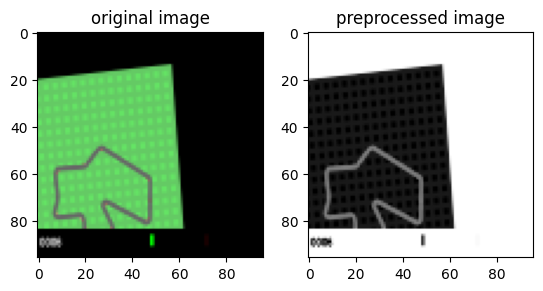

In [25]:
# show what a preprocessed image looks like
frame, _, _, _,_ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
    # Convert RGB to grayscale using the standard formula
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
    if norm:
        # Normalize the grayscale image to range [-1, 1]
        gray = gray / 128.0 - 1.0
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

In [26]:
import numpy as np
import gym
import tensorflow as tf

class Wrapper:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, env, img_stack=4, action_repeat=4):
        self.env = env
        self.img_stack = img_stack
        self.action_repeat = action_repeat
        self.die = False
        self.stack = []
        self.av_r = self.reward_memory()

    def reset(self):
        self.counter = 0
        self.die = False
        img_rgb, _ = self.env.reset()  # Correct unpacking
        img_gray = rgb2gray(img_rgb)  # Convert to grayscale
        self.stack = [img_gray] * self.img_stack  # Stack the initial frames
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for _ in range(self.action_repeat):  # Loop for action repeats
            # Clip the action values as per environment specifications
            action[0] = np.clip(action[0], -1.0, 1.0)  # Steering (-1 to 1)
            action[1] = np.clip(action[1], 0.0, 1.0)   # Gas (0 to 1)
            action[2] = np.clip(action[2], 0.0, 1.0)   # Braking (0 to 1)
            
            # Step through the environment with the clipped action
            img_rgb, reward, done, truncated, info = self.env.step(action)

            # Apply penalties and rewards
            if self.die:
                reward += 100
            if np.mean(img_rgb[:, :, 1]) > 185.0:  # Green penalty
                reward -= 0.05

            total_reward += reward

            # Calculate rolling average reward to decide on episode termination
            done = True if self.av_r(reward) <= -0.1 else done
            if done or self.die:
                break

        # Convert the latest RGB image to grayscale and update the image stack
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)  # Remove the oldest frame
        self.stack.append(img_gray)  # Add the new frame
        assert len(self.stack) == self.img_stack  # Ensure the stack size is correct

        return np.array(self.stack), total_reward, done, self.die

    @staticmethod
    def reward_memory():
        """
        Keeps track of the reward history for the last 100 steps.
        Returns a function that computes the rolling average reward.
        """
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


In [27]:
def save(agent, directory, filename, suffix):
    # Construct the file path with the given directory, filename, and suffix
    filepath = f"{directory}/{filename}_{suffix}.h5"
    
    # Save the weights of the agent's model
    agent.net.save_weights(filepath)
    print(f"Model saved to {filepath}")

## Train Agent

In [ ]:
import numpy as np
import gym
import tensorflow as tf
from collections import deque
import time

def return_suffix(j):
    suf = '0'
    for i in range(len(limits) - 1):
        if j > limits[i] and j < limits[i + 1]:
            suf = str(limits[i + 1])
            break

        i_last = len(limits) - 1
        if j > limits[i_last]:
            suf = str(limits[i_last])
            break
    return suf


def ppo_train(n_episodes=5, save_every=500):
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    timestep_after_last_save = 0
    time_start = time.time()

    running_score = 0
    state = env_wrap.reset()

    for i_episode in range(n_episodes):
        timestep = 0
        total_reward = 0

        state = env_wrap.reset()

        print(f"Initial state shape: {state.shape}")  # Check the initial state shape

        while True:
            # Check if the state shape is correct
            print(f"State shape before passing to the agent: {state.shape}")

            # Add a batch dimension (1, 4, 96, 96)
            state = tf.expand_dims(state, axis=0)  # Adding batch dimension

            # Remove unnecessary singleton dimensions if present (1, 1, 96, 96, 4) -> (1, 96, 96, 4)
            if len(state.shape) == 5:
                state = tf.squeeze(state, axis=1)  # Squeeze the second dimension

            # Ensure the shape is (1, 96, 96, 4)
            print(f"State shape after squeeze: {state.shape}")

            # Now select an action from the agent
            action, a_logp = agent.select_action(state)

            next_state, reward, done, die = env_wrap.step(
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.])
            )

            # Store the transition and update the agent
            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()

            total_reward += reward
            state = next_state

            timestep += 1
            timestep_after_last_save += 1

            if done or die:
                break

        running_score = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        s = int(time.time() - time_start)
        print(
            'Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, '
            'Time: {:02}:{:02}:{:02} '.format(i_episode, timestep,
                                              total_reward, avg_score, running_score, s // 3600, s % 3600 // 60, s % 60))

        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:
            timestep_after_last_save %= save_every
            suf = return_suffix(avg_score)
            save(agent, '/path/to/save/model', 'model_weights', suf)

        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !".format(running_score, avg_score))
            break

    return scores_array, avg_scores_array





# Initialize the agent and environment wrapper
device = 'cuda' if tf.config.list_physical_devices('GPU') else 'cpu'  # Automatically use GPU if available
agent = Agent(device)
env = gym.make('CarRacing-v2', verbose=0, render_mode='human')
env_wrap = Wrapper(env)

# Define the reward limits and the training function
limits = [200, 400, 600, 800, 830, 870, 900]

# Start training PPO
scores, avg_scores = ppo_train()


Initial state shape: (4, 96, 96)
State shape before passing to the agent: (4, 96, 96)
State shape after squeeze: (1, 4, 96, 96)


ValueError: Exception encountered when calling layer 'net_12' (type Net).

Input 0 of layer "sequential_36" is incompatible with the layer: expected shape=(None, 96, 96, 4), found shape=(1, 1, 4, 96, 96)

Call arguments received by layer 'net_12' (type Net):
  • inputs=tf.Tensor(shape=(1, 1, 4, 96, 96), dtype=float32)

: 